In [1]:
import pandas
import numpy as np
import uproot
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import gc

In [2]:
#file_name = '../../../tuples/results/DY_amcatnloFXFX_part1.root'
#file_name = '../../../tuples/results/TTTo2L2Nu_test_part1.root'
#file_name = '../../../tuples/results/TTToHadronic_PSweights_part1.root'
#file_name = '../../../tuples/results/TTToSemiLeptonic_PSweights_part1.root'
#file = uproot.open(file_name)

#file_name = '../../results/0607_all/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8.hdf5'
#file_name = '../../results/0607_all/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = '../../results/0607_all/TTToHadronic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = '../../results/0607_all/TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'

#folder='../../results/0607_all'
folder='../../results/0610_s3/'
file_name = folder + 'DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8.hdf5'
#file_name = folder + 'TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = folder + 'TTToHadronic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = folder + 'TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'


#file_name = '../../results/DY_s3.hdf5'
#file_name = '../../results/TT_had_s3.hdf5'
#file_name = '../../results/TT_lep_s2.hdf5'
#file_name = '../../results/TT_semi_s2.hdf5'
df = pandas.read_hdf(file_name)

In [3]:
df_qcd = pandas.read_hdf(folder + 'ZeroBias.hdf5')

In [13]:
#df = file['taus'].arrays(outputtype=pandas.DataFrame)
#df.columns = [ c.decode('utf-8') for c in df.columns ]

In [3]:
df_taus = df[df['gen_tau'] == 1].copy(deep=True)

In [4]:
del df
gc.collect()

111

In [6]:
df = df.append(df_taus)

In [7]:
del df_taus
gc.collect()

97

In [4]:
def ProcessDF(df):
    df['tau_vs_jet'] = pandas.Series(df['deepId_tau'] / (df['deepId_tau'] + df['deepId_jet']), index=df.index)
    df['tau_vs_mu'] = pandas.Series(df['deepId_tau'] / (df['deepId_tau'] + df['deepId_mu']), index=df.index)
    df['tau_vs_e'] = pandas.Series(df['deepId_tau'] / (df['deepId_tau'] + df['deepId_e']), index=df.index)
    df['tau_vs_all'] = pandas.Series(df['deepId_tau']
                                     / (df['deepId_tau'] + df['deepId_e'] + df['deepId_mu'] + df['deepId_jet']), index=df.index)

In [6]:
ProcessDF(df)
ProcessDF(df_qcd)

In [7]:
#presel = (df['pt'] > 20) & (df['pt'] <= 100) & (np.abs(df['eta']) < 2.3)
presel = (df['pt'] > 20) & (np.abs(df['eta']) < 2.3)

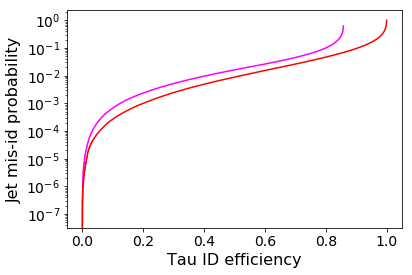

In [5]:
df_tj = df[((df['gen_tau'] == True) | (df['gen_jet'] == True)) & presel]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(df_tj['gen_tau'], df_tj['refId_jet'])
fpr, tpr, thresholds = metrics.roc_curve(df_tj['gen_tau'], df_tj['tau_vs_jet'])
plt.semilogy(tpr_ref[:-1], fpr_ref[:-1], 'magenta', tpr, fpr, 'red')
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Jet mis-id probability', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('tau_vs_jet.pdf', bbox_inches='tight')

In [8]:
def FindThresholds(df, var_name, pt_bins, target_eff):
    thr = np.zeros(len(pt_bins) - 1)
    for n in range(0, len(thr)):
        x = df[(df['gen_tau']== 1) & (df['pt'] > pt_bins[n]) & (df['pt'] <= pt_bins[n+1]) & (np.abs(df['eta']) < 2.3)]
        thr[n] = np.percentile(x[var_name], (1-target_eff) * 100)
    return thr

In [9]:
def FindThreshold(df, var_name, target_eff):
    x = df[(df['gen_tau']== 1) & (df['pt'] > 20) & (np.abs(df['eta']) < 2.3)]
    return np.percentile(x[var_name], (1-target_eff) * 100)

In [10]:
def efficiency(df, name, discr, thr):
    N = df[(df[name] == 1)].shape[0]
    n = df[(df[name] == 1) & (df[discr] > thr)].shape[0]
    eff = float(n)/N
    eff_down, eff_up = proportion_confint(n, N, 1-0.682689, 'beta')
    return eff, eff_down, eff_up

In [21]:
%load_ext Cython

In [36]:
%%cython
import numpy as np
def rate_curve(df, variables, thresholds):
    rates = np.zeros(thresholds.shape)
    events = df.groupby(['run', 'lumi', 'evt'])
    print("before n: ", df.shape[0])
    n_events = len(events)
    print("N done:", n_events)
    for v in range(0, len(variables)):
        var = variables[v]
        x = events[var].max()
        for k in range(0, thresholds.shape[0]):
            n_passed = np.count_nonzero(x > thresholds[k, v])
            rates[k, v] = float(n_passed) / n_events
    return rates

In [29]:
np.unique(df_qcd.evt).shape

(3087490,)

In [34]:
df_qcd.sort_values(by=['run', 'lumi', 'evt'], inplace=True)

In [35]:
len(df_qcd.groupby(['run', 'lumi', 'evt']))

3090241

In [13]:
def efficiency_curve(x, n_bins):
    eff = np.linspace(0, 1, num=n_bins)
    thr = np.percentile(x, (1-eff) * 100)
    return eff, thr

In [37]:
def rate_eff_curve(df_rate, df_eff, variables, n_bins):
    eff = np.zeros((n_bins, len(variables)))
    thr = np.zeros(eff.shape)
    for v in range(0, len(variables)):
        var = variables[v]
        eff[:, v], thr[:, v] = efficiency_curve(df_eff[var], n_bins)
    rates = rate_curve(df_rate, variables, thr)
    return rates, eff, thr

before n:  3533987
N done: 3090241


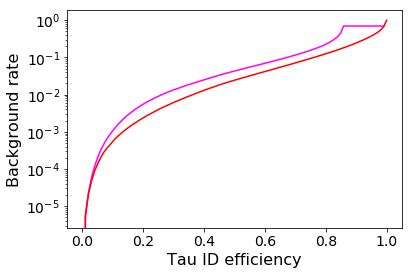

In [39]:
fpr, tpr, thresholds = rate_eff_curve(df_qcd,
                                      df[(df['gen_tau'] == True) & presel],
                                      ['refId_jet', 'tau_vs_all'], 100)
plt.semilogy(tpr[:-1, 0], fpr[:-1, 0], 'magenta', tpr[:, 1], fpr[:, 1], 'red')
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Background rate', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('tau_vs_jet.pdf', bbox_inches='tight')

In [16]:
pt = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300, 350, 400])
thrs = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#pt = np.arange(20, 210, 10)
thr_jet = FindThreshold(df, 'tau_vs_jet', 0.6)
print(thr_jet)
eff = np.zeros([len(pt)-1, 2])
eff_up = np.zeros([len(pt)-1, 2])
eff_down = np.zeros([len(pt)-1, 2])
for n in range(0, len(pt) - 1):
    x = df[(df['pt'] > pt[n]) & (df['pt'] <= pt[n+1]) & (np.abs(df['eta']) < 2.3)]
    eff[n, 0], eff_down[n, 0], eff_up[n, 0] = efficiency(x, 'gen_tau', 'tau_vs_jet', thr_jet)
    eff[n, 1], eff_down[n, 1], eff_up[n, 1] = efficiency(x, 'gen_jet', 'tau_vs_jet', thr_jet)
eff_up = eff_up - eff
eff_down = eff - eff_down

0.9140245346434328


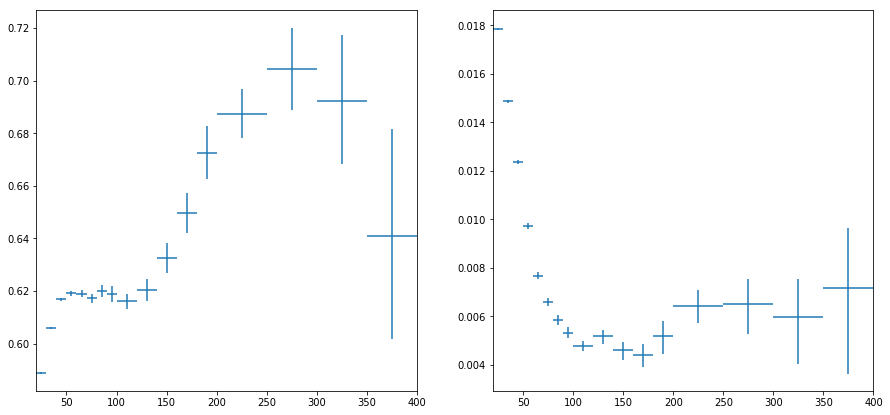

In [17]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.errorbar((pt[1:]+pt[0:-1])/2, eff[:, 0], xerr=((pt[1:]-pt[0:-1])/2), yerr=[eff_up[:, 0], eff_down[:, 0]], linestyle='None')
ax1.set_xlim([pt[0], pt[-1]])
ax2.errorbar((pt[1:]+pt[0:-1])/2, eff[:, 1], xerr=((pt[1:]-pt[0:-1])/2), yerr=[eff_up[:, 1], eff_down[:, 1]], linestyle='None')
ax2.set_xlim([pt[0], pt[-1]])
plt.show()

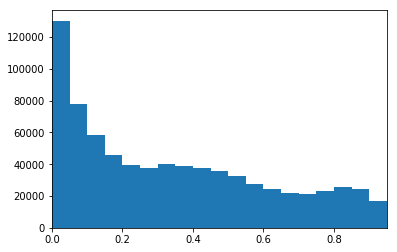

In [46]:
bins = np.arange(0, 1, 0.05)
bins = np.arange(0, 1, 0.05)
#bins = np.arange(0, 2, 0.1)
#x = df[(df['gen_tau']== 1) &(df['pt'] > 20) & (df['pt'] <= 30) & (np.abs(df['eta']) < 2.3)]
x = df[(df['gen_jet']== 1) & (df['pt'] > 20) & (df['pt'] <= 30) & (np.abs(df['eta']) < 2.3)]
#plt.hist(x['tau_vs_jet'], bins=bins)
plt.hist(x['tau_vs_jet'], bins=bins)
#plt.hist(df['pt'], bins=bins, weights=df['weight'])
#plt.hist(df[(df['gen_tau']== 1) & (df['pt'] < 30) & (df['pt'] > 20)]['weight'], bins=bins)
#plt.hist(df[(df['gen_tau']== 1)]['weight'], bins=bins)
plt.xlim([bins[0], bins[-1]]);

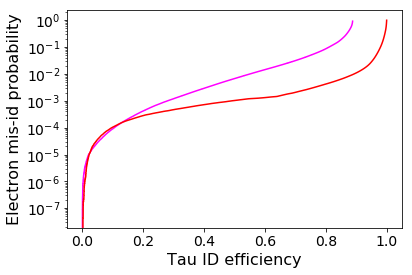

In [6]:
df_et = df[((df['gen_tau'] == True) | (df['gen_e'] == True)) & presel]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(df_et['gen_tau'], df_et['refId_e'])
fpr, tpr, thresholds = metrics.roc_curve(df_et['gen_tau'], df_et['tau_vs_e'])
plt.semilogy(tpr_ref[:-1], fpr_ref[:-1], 'magenta', tpr, fpr, 'red')
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Electron mis-id probability', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('tau_vs_ele.pdf', bbox_inches='tight')

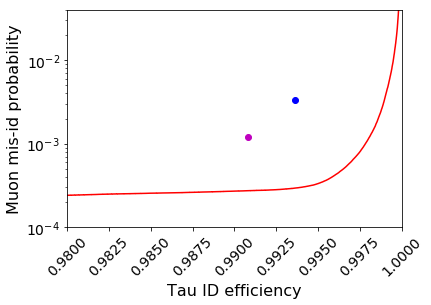

In [9]:
df_mt = df[((df['gen_tau'] == True) | (df['gen_mu'] == True)) & presel]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(df_mt['gen_tau'], df_mt['refId_mu_loose'])
fpr_ref_2, tpr_ref_2, thresholds_ref_2 = metrics.roc_curve(df_mt['gen_tau'], df_mt['refId_mu_tight'])
fpr, tpr, thresholds = metrics.roc_curve(df_mt['gen_tau'], df_mt['tau_vs_mu'])
plt.semilogy(tpr_ref[1:2], fpr_ref[1:2], 'bo', tpr_ref_2[1:2], fpr_ref_2[1:2], 'mo', tpr, fpr, 'red')
plt.ylim([1e-4, 0.04])
plt.xlim([.98, 1])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Muon mis-id probability', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.savefig('tau_vs_mu.pdf', bbox_inches='tight')